## Load Dataset

In [64]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [65]:
train = pd.read_csv('C:/Users/tjdwo/OneDrive/바탕 화면/all/train.csv', parse_dates = ['datetime'])
train.shape

(10886, 12)

In [66]:
test = pd.read_csv('C:/Users/tjdwo/OneDrive/바탕 화면/all/test.csv', parse_dates = ['datetime'])
test.shape

(6493, 9)

### Featrue Engineering

In [67]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [68]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

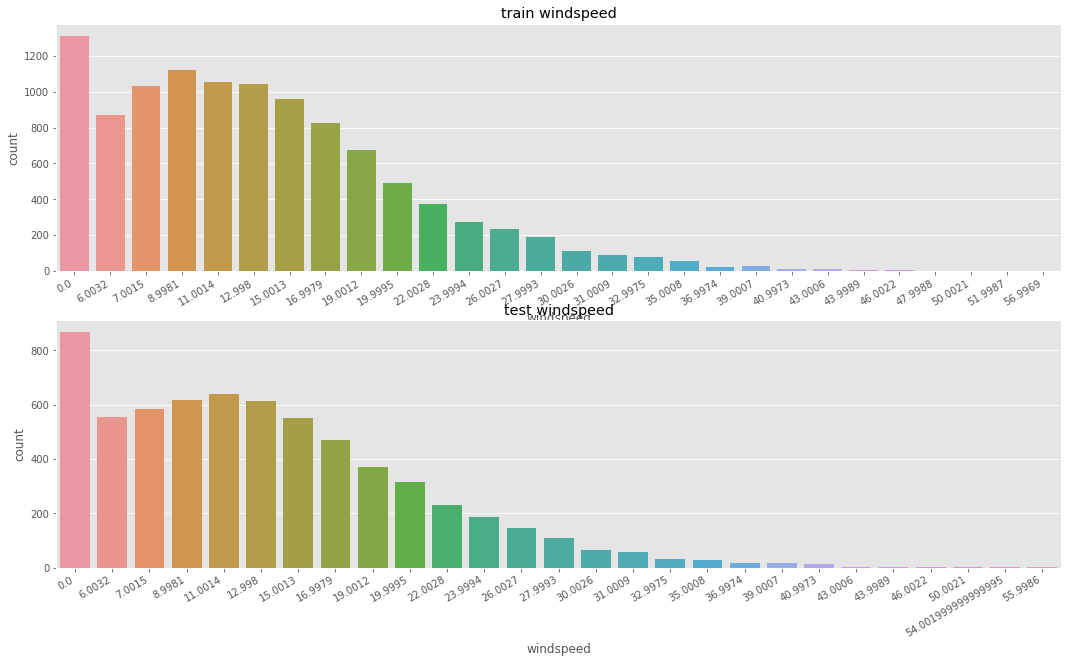

In [69]:
# widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [70]:
# # 풍속의 0값에 특정 값을 넣어준다.
# # 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [71]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [72]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

In [31]:
trainWind0 = train.loc[train['windspeed']==0]
trainWindNot0 = train.loc[train['windspeed']!=0]

In [38]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek'],
      dtype='object')

In [39]:
wCol = [ 'season', 'weather', 'temp', 'atemp', 'humidity', 'month','year']

In [40]:
trainWindNot0['windspeed'] = trainWindNot0['windspeed'].astype('str')

In [43]:
rfModel_wind = RandomForestClassifier()

In [44]:
rfModel_wind.fit(trainWindNot0[wCol], trainWindNot0['windspeed'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
wind0Values = rfModel_wind.predict(X = trainWind0[wCol])

In [46]:
wind0Values

array(['6.0032', '6.0032', '6.0032', ..., '8.9981', '12.998', '7.0015'],
      dtype=object)

In [47]:
predictWind0 = trainWind0
predcitWindNot0 = trainWindNot0

In [49]:
predictWind0['windspeed']= wind0Values

In [58]:
predictWind0.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
10826,2012-12-17 12:00:00,4,0,1,2,16.40,20.455,87,8.9981,21,211,232,2012,12,17,12,0,0,0
10829,2012-12-17 15:00:00,4,0,1,2,17.22,21.210,88,8.9981,15,196,211,2012,12,17,15,0,0,0
10846,2012-12-18 08:00:00,4,0,1,1,15.58,19.695,94,8.9981,10,652,662,2012,12,18,8,0,0,1
10860,2012-12-18 22:00:00,4,0,1,1,13.94,16.665,49,12.998,5,127,132,2012,12,18,22,0,0,1
10862,2012-12-19 00:00:00,4,0,1,1,12.30,15.910,61,7.0015,6,35,41,2012,12,19,0,0,0,2


In [52]:
train = predcitWindNot0.append(predictWind0)

In [55]:
train['windspeed'] = train['windspeed'].astype('float')

In [56]:
train.reset_index(inplace=True)

In [60]:
train.drop('index', inplace=True, axis=1)

In [62]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
10881,2012-12-17 12:00:00,4,0,1,2,16.40,20.455,87,8.9981,21,211,232,2012,12,17,12,0,0,0
10882,2012-12-17 15:00:00,4,0,1,2,17.22,21.210,88,8.9981,15,196,211,2012,12,17,15,0,0,0
10883,2012-12-18 08:00:00,4,0,1,1,15.58,19.695,94,8.9981,10,652,662,2012,12,18,8,0,0,1
10884,2012-12-18 22:00:00,4,0,1,1,13.94,16.665,49,12.9980,5,127,132,2012,12,18,22,0,0,1
10885,2012-12-19 00:00:00,4,0,1,1,12.30,15.910,61,7.0015,6,35,41,2012,12,19,0,0,0,2


In [73]:
# 0 값을 조정한다
train = predict_windspeed(train)
# test = predict_windspeed(test)
# test 데이터를 같이 넣고 하면 예측값이 좋지 않음

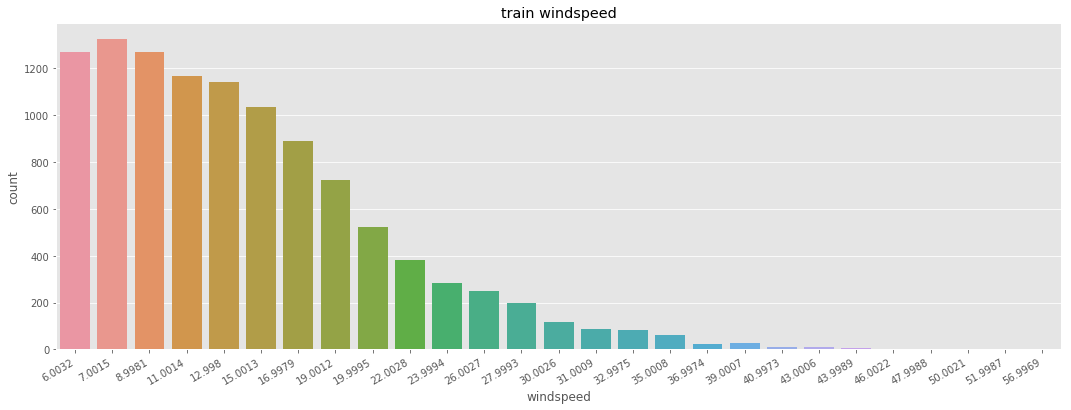

In [76]:
# windspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

## Feature Selection
- 신호와 잡을을 구분해야 한다.
- 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다

In [77]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [78]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [ ]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

In [90]:
kospi.to_csv('C:/Users/tjdwo/AI_Python_Study/Kospi.csv', encoding='euc-kr')

In [91]:
kosdaq = pd.read_csv('C:/Users/tjdwo/AI_Python_Study/result_kosdaq.csv', encoding = 'utf8')
kosdaq = kosdaq[99:]
kosdaq.head()

,Unnamed: 0,종목코드,기업명,폐지일,폐지사유
99,162,A039050,마이다스테2,2001/01/09,증권투자회사법 64조에 의한 해산사유 발생
100,161,A038770,글로벌하이1,2001/01/09,증권투자회사법 64조에 의한 해산사유 발생
101,160,A038380,KTB자산배분2,2001/01/09,증권투자회사법 64조에 의한 해산사유 발생
102,159,A038480,박현주6호,2001/01/16,증권투자회사법 64조에 의한 해산사유 발생
103,158,A039270,리젠트빅히트,2001/01/16,증권투자회사법 64조에 의한 해산사유 발생


In [92]:
kosdaq.to_csv('C:/Users/tjdwo/AI_Python_Study/kosdaq.csv', encoding='euc-kr')